In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

# Supervised Learning: Neural Networks

In [37]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import theano
import theano.tensor as T
from scipy import optimize
from IPython.html.widgets import *

theano.config.compute_test_value = 'ignore'

## McCulloch and Pitts Neuron

In 1943, McCulloch and Pitts introduced a mathematical model of a neuron. It consisted of three components:

1. A set of **weights** $w_i$ corresponding to synapses (inputs)
2. An **adder** for summing input signals; analogous to cell membrane that collects charge
3. An **activation function** for determining when the neuron fires, based on accumulated input

The neuron model is shown schematically below. On the left are input nodes $\{x_i\}$, usually expressed as a vector. The strength with which the inputs are able to deliver the signal along the synapse is determined by their corresponding weights $\{w_i\}$. The adder then sums the inputs from all the synapses:

$$h = \sum_i w_i x_i$$

The parameter $\theta$ determines whether or not the neuron fires given a weighted input of $h$. If it fires, it returns a value $y=1$, otherwise $y=0$. For example, a simple **activation function** is using $\theta$ as a simple fixed threshold:

$$y = g(h) = \left\{ \begin{array}{l}
1, \text{if } h \gt \theta \\
0, \text{if } h \le \theta
\end{array} \right.$$

this activation function may take any of several forms, such as a logistic function.

![neuron](http://d.pr/i/9AMK+)

A single neuron is not interesting, nor useful, from a learning perspective. It cannot learn; it simply receives inputs and either fires or not. Only when neurons are joined as a network can they perform useful work.

Learning takes place by changing the weights of the connections in a neural network, and by changing the parameters of the activation functions of neurons.

## Perceptron

A collection of McCullough and Pitts neurons, along with a set of input nodes connected to the inputs via weighted edges, is a perceptron, the simplest neural network.

Each neuron is independent of the others in the perceptron, in the sense that its behavior and performance depends only on its own weights and threshold values, and not of those for the other neurons. Though they share inputs, they operate independently.

The number of inputs and outputs are determined by the data. Weights are stored as a `N x K` matrix, with N observations and K neurons, with $w_{ij}$ specifying the weight on the *i*th observation on the *j*th neuron.

![perceptron](http://d.pr/i/4IWA+)

In order to use the perceptron for statistical learning, we compare the outputs $y_j$ from each neuron to the obervation target $t_j$, and adjust the input weights when they do not correspond (*e.g.* if a neuron fires when it should not have).

$$t_j - y_j$$

We use this difference to update the weight $w_{ij}$, based on the input and a desired learning rate. This results in an update rule:

$$w_{ij} \leftarrow w_{ij} + \eta (t_j - y_j) x_i$$

After an incremental improvement, the perceptron is shown the training data again, resulting in another update. This is repeated until the performance no longer improves. Having a learning rate less than one results in a more stable learning rate, though this stability is traded off against having to expose the network to the data multiple times. Typical learning rates are in the 0.1-0.4 range.

An additional input node is typically added to the perceptron model, which is a constant value (usually -1) that acts analogous to an intercept in a regression model. This establishes a baseline input for the case when all inputs are zero.

![bias](http://d.pr/i/105b5+)

## Learning with Perceptrons

1. Initialize weights $w_{ij}$ to small, random numbers.
2. For each t in T iterations
    * compute activation for each neuron *j* connected to each input vector *i*
    $$y_j = g\left( h=\sum_i w_{ij} x_i \right) = \left\{ \begin{array}{l}
1, \text{if } h \gt 0 \\
0, \text{if } h \le 0
\end{array} \right.$$
    * update weights
    $$w_{ij} \leftarrow w_{ij} + \eta (t_j - y_j) x_i$$


This algorithm is $\mathcal{O}(Tmn)$

### Example: Logical functions

Let's see how the perceptron learns by training it on a couple of of logical functions, AND and OR. For two variables `x1` and `x2`, the AND function returns 1 if both are true, or zero otherwise; the OR function returns 1 if either variable is true, or both. These functions can be expressed as simple lookup tables.

In [3]:
_and = pd.DataFrame({'x1': (0,0,1,1), 'x2': (0,1,0,1), 'y': (0,0,0,1)})
_and

,x1,x2,y
0,0,0,0
1,0,1,0
2,1,0,0
3,1,1,1


First, we need to initialize weights to small, random values (can be positive and negative).

In [4]:
w = np.random.randn(3)*1e-4

Then, a simple activation function for calculating $g(h)$:

In [5]:
g = lambda inputs, weights: np.where(np.dot(inputs, weights)>0, 1, 0)

Finally, a training function that iterates the learning algorihtm, returning the adapted weights.

In [6]:
def train(inputs, targets, weights, eta, n_iterations):

    # Add the inputs that match the bias node
    inputs = np.c_[inputs, -np.ones((len(inputs), 1))]

    for n in range(n_iterations):

        activations = g(inputs, weights);
        weights -= eta*np.dot(np.transpose(inputs), activations - targets)
        
    return(weights)

Let's test it first on the AND function.

In [7]:
inputs = _and[['x1','x2']]
target = _and['y']

w = train(inputs, target, w, 0.25, 10)

Checking the performance:

In [8]:
g(np.c_[inputs, -np.ones((len(inputs), 1))], w)

array([0, 0, 0, 1])

Thus, it has learned the function perfectly. Now for OR:

In [9]:
_or = pd.DataFrame({'x1': (0,0,1,1), 'x2': (0,1,0,1), 'y': (0,1,1,1)})
_or

,x1,x2,y
0,0,0,0
1,0,1,1
2,1,0,1
3,1,1,1


In [10]:
w = np.random.randn(3)*1e-4

In [11]:
inputs = _or[['x1','x2']]
target = _or['y']

w = train(inputs, target, w, 0.25, 20)

In [12]:
g(np.c_[inputs, -np.ones((len(inputs), 1))], w)

array([0, 1, 1, 1])

Also 100% correct.

Now try running the model on the XOR function, where a one is returned for either `x1` or `x2` being true, but *not* both. What happens here?

In [13]:
# Write your answer here

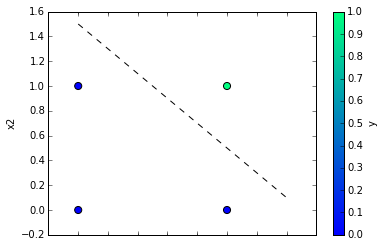

In [14]:
_and.plot(kind='scatter', x='x1', y='x2', c='y', s=50, colormap='winter')
plt.plot(np.linspace(0,1.4), 1.5 - 1*np.linspace(0,1.4), 'k--');

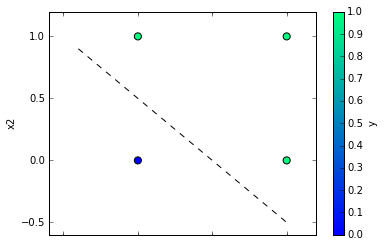

In [15]:
_or.plot(kind='scatter', x='x1', y='x2', c='y', s=50, colormap='winter')
plt.plot(np.linspace(-.4,1), .5 - 1*np.linspace(-.4,1), 'k--');

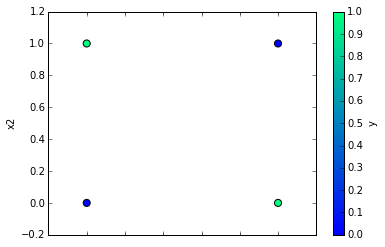

In [16]:
_xor = pd.DataFrame({'x1': (0,0,1,1), 'x2': (0,1,0,1), 'y': (0,1,1,0)})

_xor.plot(kind='scatter', x='x1', y='x2', c='y', s=50, colormap='winter');

The perceptron tries to find a separating hyperplane for the two response classes. Namely, a set of weights that satisfies:

$$\mathbf{x_1}\mathbf{w}^T=0$$

and:

$$\mathbf{x_2}\mathbf{w}^T=0$$

Hence,

$$\begin{aligned}
\mathbf{x}_1\mathbf{w}^T &= \mathbf{x}_2\mathbf{w}^T \\
\Rightarrow (\mathbf{x}_1 - \mathbf{x}_2) \mathbf{w}^T &= 0
\end{aligned}$$

This means that either the norms of $\mathbf{x}_1 - \mathbf{x}_2$ or $\mathbf{w}$ are zero, or the cosine of the angle between them is equal to zero, due to the identity:

$$\mathbf{a}\mathbf{b} = \|a\| \|b\| \cos \theta$$

Since there is no reason for the norms to be zero in general, we need the two vectors to be at right angles to one another. So, we need a weight vector that is perpendicular to the decision boundary.

Clearly, for the XOR function, the output classes are not linearly separable. So, the algorithm does not converge on an answer, but simply cycles through two incorrect solutions.

## Multi-layer Perceptron

The solution to fitting more complex (*i.e.* non-linear) models with neural networks is to use a more complex network that consists of more than just a single perceptron. The take-home message from the perceptron is that all of the learning happens by adapting the synapse weights until prediction is satisfactory. Hence, a reasonable guess at how to make a perceptron more complex is to simply add more weights.

There are two ways to add complexity:

1. Add backward connections, so that output neurons feed back to input nodes, resulting in a **recurrent network**
2. Add neurons between the input nodes and the outputs, creating an additional ("hidden") layer to the network, resulting in a **multi-layer perceptron**

The latter approach is more common in applications of neural networks.

![multilayer](http://d.pr/i/14BS1+)

How to train a multilayer network is not intuitive. Propagating the inputs forward over two layers is straightforward, since the outputs from the hidden layer can be used as inputs for the output layer. However, the process for updating the weights based on the prediction error is less clear, since it is difficult to know whether to change the weights on the input layer or on the hidden layer in order to improve the prediction.

Updating a multi-layer perceptron (MLP) is a matter of moving forward through the network, calculating outputs given inputs and current weight estimates, then moving backward updating weights according to the resulting error from forward propagation. In this sense, it is similar to a single-layer perceptron, except it has to be done twice, once for each layer (in principle, we can add additional hidden layers, but without sacrificing generality, I will keep it simple).

### Error back-propagation

We update the weights in a MLP using **back-propagation** of the prediction errors, which is essentially a form of gradient descent, as we have used previously for optimization.

First, for the multi-layer perceptron we need to modify the error function, which in the single-layer case was a simple difference between the predicted and observed outputs. Because we will be summing errors, we have to avoid having errors in different directions cancelling each other out, so a sum of squares error is more appropriate:

$$E(t,y) = \frac{1}{2} \sum_i (t_i - y_i)^2$$

It is on this function that we will perform gradient descent, since the goal is to minimize the error. Specificially, we will differentiate with respect to the weights, since it is the weights that we are manipulating in order to get better predictions.

Recall that the error is a function of the threshold function

$$E(\mathbf{w}) = \frac{1}{2} \sum_i (t_i - y_i)^2 = \frac{1}{2} \sum_i \left(t_i - g\left[ \sum_j w_{ij} a_j \right]\right)^2$$

So, we will also need to differentiate that. However, the threshold function we used in the single-layer perceptron was discontinuous, making it non-differentiable. Thus, we need to modify it as well. An alternative is to employ some type of sigmoid function, such as the logistic, which can be parameterized to resemble a threshold function, but varies smoothly across its range.

$$g(h) = \frac{1}{1 + \exp(-\beta h)}$$

None

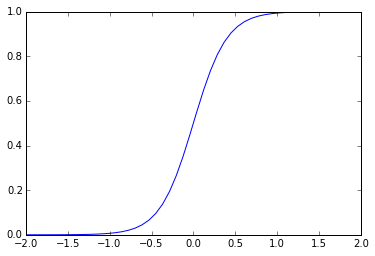

In [17]:
logistic = lambda h, beta: 1./(1 + np.exp(-beta * h))

@interact
def logistic_plot(beta=5):
    hvals = np.linspace(-2, 2)
    plt.plot(hvals, logistic(hvals, beta))

This has the advantage of having a simple derivative:

$$\frac{dg}{dh} = \beta g(h)(1 - g(h))$$

Alternatively, the hyperbolic tangent function is also sigmoid:

$$g(h) = \tanh(h) = \frac{\exp(h) - \exp(-h)}{\exp(h) + \exp(-h)}$$

None

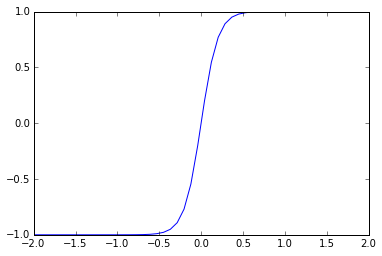

In [18]:
hyperbolic_tangent = lambda h: (np.exp(h) - np.exp(-h)) / (np.exp(h) + np.exp(-h))

@interact
def tanh_plot(theta=5):
    hvals = np.linspace(-2, 2)
    h = hvals*theta
    plt.plot(hvals, hyperbolic_tangent(h))

Notice that the hyperbolic tangent function asymptotes at -1 and 1, rather than 0 and 1, which is sometimes beneficial, and its derivative is simple:

$$\frac{d \tanh(x)}{dx} = 1 - \tanh^2(x)$$

Performing gradient descent will allow us to change the weights in the direction that optimially reduces the error. The next trick will be to employ the **chain rule** to decompose how the error changes as a function of the input weights into the change in error as a function of changes in the inputs to the weights, mutliplied by the changes in input values as a function of changes in the weights. 

$$\frac{\partial E}{\partial w} = \frac{\partial E}{\partial h}\frac{\partial h}{\partial w}$$

This will allow us to write a function describing the activations of the output weights as a function of the activations of the hidden layer nodes and the output weights, which will allow us to propagate error backwards through the network.

The second term in the chain rule simplifies to:

$$\begin{align}
\frac{\partial h_k}{\partial w_{jk}} &= \frac{\partial \sum_l w_{lk} a_l}{\partial w_{jk}}  \\
&= \sum_l \frac{\partial w_{lk} a_l}{\partial w_{jk}} \\
& = a_j
\end{align}$$

where $a_j$ is the activation of the jth hidden layer neuron.

For the first term in the chain rule above, we decompose it as well:

$$\frac{\partial E}{\partial h_k} = \frac{\partial E}{\partial y_k}\frac{\partial y_k}{\partial h_k} = \frac{\partial E}{\partial g(h_k)}\frac{\partial g(h_k)}{\partial h_k}$$

The second term of this chain rule is just the derivative of the activation function, which we have chosen to have a conveneint form, while the first term simplifies to:

$$\frac{\partial E}{\partial g(h_k)} = \frac{\partial}{\partial g(h_k)}\left[\frac{1}{2} \sum_k (t_k - y_k)^2 \right] = t_k - y_k$$

Combining these, and assuming (for illustration) a logistic activiation function, we have the gradient:

$$\frac{\partial E}{\partial w} = (t_k - y_k) y_k (1-y_k) a_j$$

Which ends up getting plugged into the weight update formula that we saw in the single-layer perceptron:

$$w_{jk} \leftarrow w_{jk} - \eta (t_k - y_k) y_k (1-y_k) a_j$$

Note that here we are *subtracting* the second term, rather than adding, since we are doing gradient descent.

We can now outline the MLP learning algorithm:

1. Initialize all $w_{jk}$ to small random values
2. Iterate until learning completes:
    + For each input vector, run the network forward:
        * compute activation of each neuron $j$ in hidden layer:
        $$h_j = \sum_i x_i v_{ij}$$
        $$a_j = g(h_j) = \frac{1}{1 + \exp(-\beta h_j)}$$
        * when the output layer is reached, calculate outputs similarly:
        $$h_k = \sum_k a_j w_{jk}$$
        $$y_k = g(h_k) = \frac{1}{1 + \exp(-\beta h_k)}$$
    + Then run the network backward:
        * compute error at output:
        $$\delta_k = (t_k - y_k) y_k (1-y_k)$$
        * compute error of the hidden layers:
        $$\delta_{hj} = \left[\sum_k w_{jk} \delta_k \right] a_j(1-a_j)$$
        * update output layer weights:
        $$w_{jk} \leftarrow w_{jk} - \eta \delta_k a_j$$
        * update hidden layer weights:
        $$v_{ij} \leftarrow v_{ij} - \eta \delta_{hj} x_i$$
    + For best performance, shuffle input vectors to avoid training in the same order

Its important to be aware that because gradient descent is a hill-climbing (or descending) algorithm, it is liable to be caught in local minima with respect to starting values. Therefore, it is worthwhile training several networks using a range of starting values for the weights, so that you have a better chance of discovering a globally-competitive solution.

One useful performance enhancement for the MLP learning algorithm is the addition of **momentum** to the weight updates. This is just a coefficient on the previous weight update that increases the correlation between the current weight and the weight after the next update. This is particularly useful for complex models, where falling into local mimima is an issue; adding momentum will give some weight to the previous direction, making the resulting weights essentially a weighted average of the two directions. Adding momentum, along with a smaller learning rate, usually results in a more stable algorithm with quicker convergence. When we use momentum, we lose this guarantee, but this is generally seen as a small price to pay for the improvement momentum usually gives.

A weight update with momentum looks like this:

$$w_{jk} \leftarrow w_{jk} - \eta \delta_k a_j + \alpha \Delta w_{jk}^{t-1}$$

where $\alpha$ is the momentum parameter and $\Delta w_{jk}^{t-1}$ the update from the previous iteration.

The multi-layer pereptron is implemented below in the `MLP` class. The implementation uses the scikit-learn interface, so it is uses in the same way as other supervised learning algorithms in that package.

In [19]:
class MLP(object):
    
    def __init__(self, reg_lambda=0, epsilon_init=0.12, hidden_layer_size=25, 
                 method='CG', maxiter=500):
        self.reg_lambda = reg_lambda
        self.epsilon_init = epsilon_init
        self.hidden_layer_size = hidden_layer_size
        self.activation_func = self.sigmoid
        self.activation_func_prime = self.sigmoid_prime
        self.method = method
        self.maxiter = maxiter
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def sigmoid_prime(self, z):
        sig = self.sigmoid(z)
        return sig * (1 - sig)
    
    def sumsqr(self, a):
        return np.sum(a ** 2)
    
    def rand_init(self, l_in, l_out):
        return np.random.rand(l_out, l_in + 1) * 2 * self.epsilon_init - self.epsilon_init
    
    def pack_thetas(self, t1, t2):
        return np.concatenate((t1.reshape(-1), t2.reshape(-1)))
    
    def unpack_thetas(self, thetas, input_layer_size, hidden_layer_size, num_labels):
        t1_start = 0
        t1_end = hidden_layer_size * (input_layer_size + 1)
        t1 = thetas[t1_start:t1_end].reshape((hidden_layer_size, input_layer_size + 1))
        t2 = thetas[t1_end:].reshape((num_labels, hidden_layer_size + 1))
        return t1, t2
    
    def _forward(self, X, t1, t2):
        m = X.shape[0]
        ones = None
        if len(X.shape) == 1:
            ones = np.array(1).reshape(1,)
        else:
            ones = np.ones(m).reshape(m,1)
        
        # Input layer
        a1 = np.hstack((ones, X))
        
        # Hidden Layer
        z2 = np.dot(t1, a1.T)
        a2 = self.activation_func(z2)
        a2 = np.hstack((ones, a2.T))
        
        # Output layer
        z3 = np.dot(t2, a2.T)
        a3 = self.activation_func(z3)
        
        return a1, z2, a2, z3, a3
    
    def function(self, thetas, input_layer_size, hidden_layer_size, num_labels, X, y, reg_lambda):
        
        t1, t2 = self.unpack_thetas(thetas, input_layer_size, hidden_layer_size, num_labels)
        
        m = X.shape[0]
        Y = np.eye(num_labels)[y]
        
        _, _, _, _, h = self._forward(X, t1, t2)
        costPositive = -Y * np.log(h).T
        costNegative = (1 - Y) * np.log(1 - h).T
        cost = costPositive - costNegative
        J = np.sum(cost) / m
        
        if reg_lambda != 0:
            t1f = t1[:, 1:]
            t2f = t2[:, 1:]
            reg = (self.reg_lambda / (2 * m)) * (self.sumsqr(t1f) + self.sumsqr(t2f))
            J += reg
            
        return J
        
    def function_prime(self, thetas, input_layer_size, hidden_layer_size, num_labels, X, y, reg_lambda):
        
        t1, t2 = self.unpack_thetas(thetas, input_layer_size, hidden_layer_size, num_labels)
        
        m = X.shape[0]
        t1f = t1[:, 1:]
        t2f = t2[:, 1:]
        Y = np.eye(num_labels)[y]
        
        Delta1, Delta2 = 0, 0
        for i, row in enumerate(X):
            
            a1, z2, a2, z3, a3 = self._forward(row, t1, t2)
            
            # Backprop
            d3 = a3 - Y[i, :].T
            d2 = np.dot(t2f.T, d3) * self.activation_func_prime(z2)
            
            Delta2 += np.dot(d3[np.newaxis].T, a2[np.newaxis])
            Delta1 += np.dot(d2[np.newaxis].T, a1[np.newaxis])
            
        Theta1_grad = (1 / m) * Delta1
        Theta2_grad = (1 / m) * Delta2
        
        if reg_lambda != 0:
            Theta1_grad[:, 1:] = Theta1_grad[:, 1:] + (reg_lambda / m) * t1f
            Theta2_grad[:, 1:] = Theta2_grad[:, 1:] + (reg_lambda / m) * t2f
        
        return self.pack_thetas(Theta1_grad, Theta2_grad)
    
    def fit(self, X, y):
        
        num_features = X.shape[0]
        input_layer_size = X.shape[1]
        num_labels = len(set(y))
        
        theta1_0 = self.rand_init(input_layer_size, self.hidden_layer_size)
        theta2_0 = self.rand_init(self.hidden_layer_size, num_labels)
        thetas0 = self.pack_thetas(theta1_0, theta2_0)
        
        options = {'maxiter': self.maxiter}
        _res = optimize.minimize(self.function, thetas0, jac=self.function_prime, method=self.method, 
                    args=(input_layer_size, self.hidden_layer_size, num_labels, X, y, 0), options=options)
        
        self.t1, self.t2 = self.unpack_thetas(_res.x, input_layer_size, self.hidden_layer_size, num_labels)
    
    def predict(self, X):
        return self.predict_proba(X).argmax(0)
    
    def predict_proba(self, X):
        _, _, _, _, h = self._forward(X, self.t1, self.t2)
        return h

Let's initialize a MLP classifier, specifying the conjugate gradient minimization method.

In [20]:
clf = MLP(method='CG')

Now we can confirm that it solves a non-linear classification, using the simple XOR example

In [21]:
X = _xor[['x1','x2']].values
y = _xor['y'].values

In [22]:
clf.fit(X,y)

In [23]:
clf.predict(X)

array([0, 1, 1, 0])

For a somewhat more sophisiticated example, we can use the iris dataset included with scikit-learn.

In [24]:
import sklearn.datasets as datasets
from sklearn import cross_validation

iris = datasets.load_iris()
X = iris.data
y = iris.target

In [25]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.4)

In [26]:
clf = MLP()
clf.fit(X_train, y_train)

Since we used the scikit-learn interface, its easy to take advantage of the `metrics` module to evaluate the MLP's performance.

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy_score(y_test, clf.predict(X_test))

0.93333333333333335

In [28]:
confusion_matrix(y_test, clf.predict(X_test))

array([[23,  0,  0],
       [ 0, 15,  4],
       [ 0,  0, 18]])

### Neural network specification

The MLP implemented above uses a single hidden layer, though it allows a user-specified number of hidden layer nodes (defaults to 25). It is worth considering whether it is useful having **multiple hidden layers**, and whether more hidden nodes is desirable.

Unfortunately, there is no theory to guide the choice of hidden node number. As a result, we are left to experiment with this parameter, perhaps in some systematic fashion such as cross-validation.

Adding additional layers presents only additional "bookkeeping" overhead to the user, with the weight updating becoming more complicated as layers are added. So, we don't want to add more hidden layers if it does not pay off in performance. It turns out that two or three layers (including the output layer) can be shown to approximate almost any smooth function. Combining 3 sigmoid functions allows local responses to be approximated with arbitrary accuracy. This is sufficient for determining any decision boundary.

### Neural network validation

Just as with other supervised learning algorithms, neural networks can be under- or over-fit to a training dataset. The degree to which a network is trained to a particular dataset depends on how long we train it on that dataset. Every time we run the MLP learning algorithm over a dataset (an **epoch**), it reduces the prediction error for that dataset. Thus, the number of epochs should be tuned as a hyperparameter, stopping when the testing-training error gap begins to widen.

Note that though we can also use cross-validation to tune the number of hidden layers in the network, there is no risk of overfitting by having too many layers.

### Example: Epoch tuning for MLPs

The dataset `pima-indians-diabetes.data.txt` in your data folder contains eight measurements taken from a group of Pima Native Americans in Arizona, along with an indicator of the onset of diabetes. Use the MLP class to fit a neural network classifier to this dataset, and use cross-validation to examine the optimal number of epochs to use in training.

1. Number of times pregnant
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. Diastolic blood pressure (mm Hg)
4. Triceps skin fold thickness (mm)
5. 2-Hour serum insulin (mu U/ml)
6. Body mass index (weight in kg/(height in m)^2)
7. Diabetes pedigree function
8. Age (years)
9. Class variable (0 or 1)

In [29]:
pima = pd.read_csv('../data/pima-indians-diabetes.data.txt', header=None)
pima.head()

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Example: Mulitilayer perceptron in Theano

Recall the Theano package, introduced earlier in the course; it is designed to evaluate expressions efficiently, and one of its key features is that it automatically differentiates expressions. This saves us from having to code a gradient function by hand. In principle, we could also use Theano to parallelize a neural network using GPUs, but we will not explore that here.

### Layer class

Again using an object-oriented approach, we will code our multilayer perceptron as a series of `Layer` classes, then apply each successively to the input to produce the network output.  The `Layer` class stores a weight matrix and a bias vector and includes a function for computing output.  

Note that if we weren't using Theano, we might expect the `output` method to take in a vector and return the layer's activation in response to this input.  However, with Theano, the `output` function is instead meant to be used to _create_ (using `theano.function`) a function which can take in a vector and return the layer's activation.  So, if you were to pass, say, a `np.ndarray` to the `Layer` class's `output` method, it would raise an error.  Instead, we'll construct a function for actually computing the `Layer`'s activation outside of the class itself.

In [30]:
class Layer(object):
    
    def __init__(self, W_init, b_init, activation):
        '''
        A layer of a neural network, computes s(Wx + b) where s is a nonlinearity and x is the input vector.

        :parameters:
            - W_init : np.ndarray, shape=(n_output, n_input)
                Values to initialize the weight matrix to.
            - b_init : np.ndarray, shape=(n_output,)
                Values to initialize the bias vector
            - activation : theano.tensor.elemwise.Elemwise
                Activation function for layer output
        '''
        
        # Retrieve the input and output dimensionality based on W's initialization
        n_output, n_input = W_init.shape
        # Make sure b is n_output in size
        assert b_init.shape == (n_output,)
        
        # All parameters should be shared variables.
        # They're used in this class to compute the layer output,
        # but are updated elsewhere when optimizing the network parameters.
        # Note that we are explicitly requiring that W_init has the theano.config.floatX dtype
        self.W = theano.shared(value=W_init.astype(theano.config.floatX),
                               # The name parameter is solely for printing purporses
                               name='W',
                               # Setting borrow=True allows Theano to use user memory for this object.
                               # It can make code slightly faster by avoiding a deep copy on construction.
                               # For more details, see
                               # http://deeplearning.net/software/theano/tutorial/aliasing.html
                               borrow=True)
        
        # We can force our bias vector b to be a column vector using numpy's reshape method.
        # When b is a column vector, we can pass a matrix-shaped input to the layer
        # and get a matrix-shaped output, thanks to broadcasting (described below)
        self.b = theano.shared(value=b_init.reshape(-1, 1).astype(theano.config.floatX),
                               name='b',
                               borrow=True,
                               # Theano allows for broadcasting, similar to numpy.
                               # However, you need to explicitly denote which axes can be broadcasted.
                               # By setting broadcastable=(False, True), we are denoting that b
                               # can be broadcast (copied) along its second dimension in order to be
                               # added to another variable.  For more information, see
                               # http://deeplearning.net/software/theano/library/tensor/basic.html
                               broadcastable=(False, True))
        
        self.activation = activation
        # We'll compute the gradient of the cost of the network with respect to the parameters in this list.
        self.params = [self.W, self.b]
        
    def output(self, x):
        '''
        Compute this layer's output given an input
        
        :parameters:
            - x : theano.tensor.var.TensorVariable
                Theano symbolic variable for layer input

        :returns:
            - output : theano.tensor.var.TensorVariable
                Mixed, biased, and activated x
        '''
        # Compute linear mix
        lin_output = T.dot(self.W, x) + self.b
        
        # Output is just linear mix if no activation function
        # Otherwise, apply the activation function
        return (lin_output if self.activation is None else self.activation(lin_output))

### MLP class

Most of the functionality of our MLP is contained in the `Layer` class; the `MLP` class is essentially just a container for a list of `Layer`s and their parameters.  The `output` function simply recursively computes the output for each layer.  Finally, the `squared_error` returns the squared Euclidean distance between the output of the network given an input and the desired (ground truth) output.  This function is meant to be used as a cost in the setting of minimizing cost over some training data.  As above, the `output` and `squared error` functions are not to be used for actually computing values; instead, they're to be used to create functions which are used to compute values.

In [31]:
class MLP(object):
    
    def __init__(self, learning_rate=0.01, momentum=0.9, max_iteration=20):
        '''
        Multi-layer perceptron class, computes the composition of a sequence of Layers

        :parameters:
            - W_init : list of np.ndarray, len=N
                Values to initialize the weight matrix in each layer to.
                The layer sizes will be inferred from the shape of each matrix in W_init
            - b_init : list of np.ndarray, len=N
                Values to initialize the bias vector in each layer to
            - activations : list of theano.tensor.elemwise.Elemwise, len=N
                Activation function for layer output for each layer
        '''
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.max_iteration = max_iteration
        
    def output(self, x):
        '''
        Compute the MLP's output given an input
        
        :parameters:
            - x : theano.tensor.var.TensorVariable
                Theano symbolic variable for network input

        :returns:
            - output : theano.tensor.var.TensorVariable
                x passed through the MLP
        '''
        # Recursively compute output
        for layer in self.layers:
            x = layer.output(x)
        return x

    def squared_error(self, x, y):
        '''
        Compute the squared euclidean error of the network output against the "true" output y
        
        :parameters:
            - x : theano.tensor.var.TensorVariable
                Theano symbolic variable for network input
            - y : theano.tensor.var.TensorVariable
                Theano symbolic variable for desired network output

        :returns:
            - error : theano.tensor.var.TensorVariable
                The squared Euclidian distance between the network output and y
        '''
        return T.sum((self.output(x) - y)**2)
    
    def fit(self, X, y):
        
        # First, set the size of each layer (and the number of layers)
        # Input layer size is training data dimensionality (2)
        # Output size is just 1-d: class label - 0 or 1
        # Finally, let the hidden layers be twice the size of the input.
        # If we wanted more layers, we could just add another layer size to this list.
        layer_sizes = [X.shape[0], X.shape[0]*2, 1]
        # Set initial parameter values
        W_init = []
        b_init = []
        activations = []
        for n_input, n_output in zip(layer_sizes[:-1], layer_sizes[1:]):
            # Getting the correct initialization matters a lot for non-toy problems.
            # However, here we can just use the following initialization with success:
            # Normally distribute initial weights
            W_init.append(np.random.randn(n_output, n_input))
            # Set initial biases to 1
            b_init.append(np.ones(n_output))
            # We'll use sigmoid activation for all layers
            # Note that this doesn't make a ton of sense when using squared distance
            # because the sigmoid function is bounded on [0, 1].
            activations.append(T.nnet.sigmoid)
        
        # Initialize lists of layers
        self.layers = []
        # Construct the layers
        for W, b, activation in zip(W_init, b_init, activations):
            self.layers.append(Layer(W, b, activation))

        # Combine parameters from all layers
        self.params = []
        for layer in self.layers:
            self.params += layer.params

        # Create Theano variables for the MLP input
        mlp_input = T.matrix('mlp_input')
        # ... and the desired output
        mlp_target = T.vector('mlp_target')

        # Create a function for computing the cost of the network given an input
        cost = self.squared_error(mlp_input, mlp_target)
        # Create a theano function for training the network
        train = theano.function([mlp_input, mlp_target], cost,
                    updates=gradient_updates_momentum(cost, self.params, self.learning_rate, self.momentum))
        # Create a theano function for computing the MLP's output given some input
        mlp_output = theano.function([mlp_input], self.output(mlp_input))
        
        iteration = 0
        # We'll only train the network with 20 iterations.
        # A more common technique is to use a hold-out validation set.
        # When the validation error starts to increase, the network is overfitting,
        # so we stop training the net.  This is called "early stopping", which we won't do here.
        while iteration < self.max_iteration:
            # Train the network using the entire training set.
            # With large datasets, it's much more common to use stochastic or mini-batch gradient descent
            # where only a subset (or a single point) of the training set is used at each iteration.
            # This can also help the network to avoid local minima.
            self.current_cost_ = train(X, y)
            
            # Get the current network output for all points in the training set
            self.current_output_ = mlp_output(X)
            # We can compute the accuracy by thresholding the output
            # and computing the proportion of points whose class match the ground truth class.
            self.accuracy_ = np.mean((self.current_output_ > .5) == y)

            iteration += 1

### Gradient descent

To train the network, we will minimize the cost (squared Euclidean distance of network output vs. ground-truth) over a training set using gradient descent.  

In Theano, we store the previous parameter update as a shared variable so that its value is preserved across iterations.  Then, during the gradient update, we not only update the parameters, but we also update the previous parameter update shared variable.

In [32]:
def gradient_updates_momentum(cost, params, learning_rate, momentum):
    '''
    Compute updates for gradient descent with momentum
    
    :parameters:
        - cost : theano.tensor.var.TensorVariable
            Theano cost function to minimize
        - params : list of theano.tensor.var.TensorVariable
            Parameters to compute gradient against
        - learning_rate : float
            Gradient descent learning rate
        - momentum : float
            Momentum parameter, should be at least 0 (standard gradient descent) and less than 1
   
    :returns:
        updates : list
            List of updates, one for each parameter
    '''
    # Make sure momentum is a sane value
    assert momentum < 1 and momentum >= 0
    # List of update steps for each parameter
    updates = []
    # Just gradient descent on cost
    for param in params:
        # For each parameter, we'll create a param_update shared variable.
        # This variable will keep track of the parameter's update step across iterations.
        # We initialize it to 0
        param_update = theano.shared(param.get_value()*0., broadcastable=param.broadcastable)
        # Each parameter is updated by taking a step in the direction of the gradient.
        # However, we also "mix in" the previous step according to the given momentum value.
        # Note that when updating param_update, we are using its old value and also the new gradient step.
        updates.append((param, param - learning_rate*param_update))
        # Note that we don't need to derive backpropagation to compute updates - just use T.grad!
        updates.append((param_update, momentum*param_update + (1. - momentum)*T.grad(cost, param)))
    return updates

### Toy example

We'll train our neural network to classify two Gaussian-distributed clusters in 2d space.

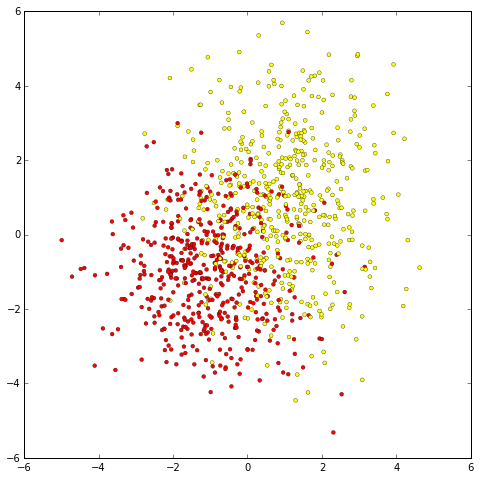

In [33]:
# Training data - two randomly-generated Gaussian-distributed clouds of points in 2d space
np.random.seed(0)
# Number of points
N = 1000
# Labels for each cluster
y = np.random.random_integers(0, 1, N)
# Mean of each cluster
means = np.array([[-1, 1], [-1, 1]])
# Covariance (in X and Y direction) of each cluster
covariances = np.random.random_sample((2, 2)) + 1
# Dimensions of each point
X = np.vstack([np.random.randn(N)*covariances[0, y] + means[0, y],
               np.random.randn(N)*covariances[1, y] + means[1, y]])
# Plot the data
plt.figure(figsize=(8, 8))
plt.scatter(*X, c=y, lw=.3, s=15, cmap=plt.cm.autumn)
plt.axis([-6, 6, -6, 6])
plt.show()

In [38]:
mlp = MLP()

In [39]:
mlp.fit(X, y)

In [40]:
print('Cost: {:.3f}, Accuracy: {:.3f}'.format(float(mlp.current_cost_), mlp.accuracy_))

Cost: 121.416, Accuracy: 0.833


## References

T. Hastie, R. Tibshirani and J. Friedman. (2009) [Elements of Statistical Learning: Data Mining, Inference, and Prediction](http://statweb.stanford.edu/~tibs/ElemStatLearn/), second edition. Springer.

S. Marsland. (2009) [Machine Learning: An Algorithmic Perspective](Machine Learning: An Algorithmic Perspectivehttp://seat.massey.ac.nz/personal/s.r.marsland/MLBook.html). CRC Press.

D. Rodriguez. (2013) [Basic [1 hidden layer] neural network on Python](http://danielfrg.com/blog/2013/07/03/basic-neural-network-python/).